In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('default')
import os 
import sys
sys_path = sys.path.copy()
sys.path.append('../')
import utils.utils as utils
sys.path = sys_path
plot_dir = '../output/plots/'

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
output_dir='../output/'

In [18]:
# Code for pretty plots
# https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
import seaborn as sns
label_text_color='#555555'
text_color="black"
accent_color="lightgrey"
sns.set(font="Franklin Gothic Book",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": accent_color,
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": text_color,
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": text_color,
 "xtick.bottom": True,
 "xtick.color": accent_color,
 "xtick.labelcolor": label_text_color,
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": label_text_color,
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":18,
                                "axes.labelsize":18})
tu_c1='#004E8A'

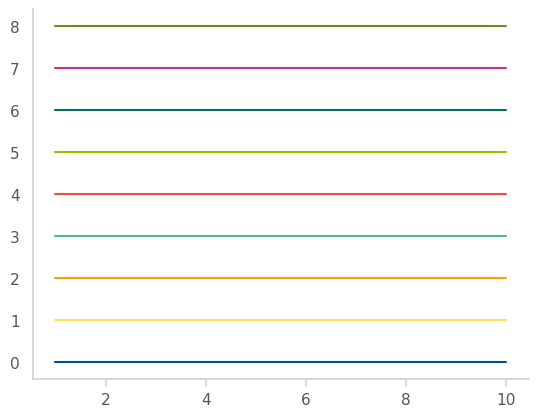

In [19]:
COLORS = ['#004E8A', '#B90F22', '#FFE05C', '#F5A300', '#00715E', '#50B695', '#C9308E', '#6A8B22']
COLORS = ['#004E8A', '#FFE05C', '#F5A300', '#50B695', '#E9503E', '#99C000', '#00715E', '#C9308E', '#6A8B22']

# 1c (adapt), 4d, 6a (lora-q), 7b (lora-v), 10a (adapt-emo), 3d, 3a, 9c
col_by_method = {'gate_lora_query':'#FFE05C', 'gate_lora_value':'#F5A300', 'gate_adapter-distress':'#004E8A', 'gate_adapter-empathy':'#004E8A', 'gate_adapter-emotion':'#50B695', 'gate_prefix':'#E9503E'}
def get_color(i, method_name=None):
    """Either get color by method name or i

    Args:
        i (_type_): _description_
        method_name (str, optional): _description_. Defaults to ''.
    """
    col = '#000000'
    if method_name and method_name in col_by_method.keys():
        col = col_by_method[method_name]
    else:
        i = i % len(COLORS)  # if index too long, start with color from beginning again
        col = COLORS[i]
    
    return col

get_color(6)
for i, col in enumerate(COLORS):
    y = np.array([1,1,1,1,1,1,1,1,1,1]) * i
    plt.plot([1,2,3,4,5,6,7,8,9,10], y, c=col)
plt.show()

In [20]:
gates = None
gates = pd.read_csv('../output/multiinput_pelt_unified_apl_bert_1e-4/distress/gates.csv')
gates

,Unnamed: 0,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix,encoder_layer,epoch,split,is_in_train
0,0,0.488449,0.398699,0.478547,0.528903,0,1.0,train,True
1,1,0.531000,0.395376,0.477123,0.526924,0,1.0,train,True
2,2,0.506241,0.403368,0.478658,0.524013,0,1.0,train,True
3,3,0.512950,0.433679,0.491382,0.513690,0,1.0,train,True
4,4,0.522358,0.413687,0.483690,0.519234,0,1.0,train,True
...,...,...,...,...,...,...,...,...,...
727915,727915,0.716140,0.909500,0.770342,0.724159,11,15.0,test,False
727916,727916,0.765721,0.914943,0.815914,0.772884,11,15.0,test,False
727917,727917,0.726152,0.912307,0.785423,0.737328,11,15.0,test,False
727918,727918,0.704515,0.895840,0.748403,0.757275,11,15.0,test,False


In [21]:
encoder_layers = sorted(set(gates['encoder_layer']))
# get eval and train of last epoch while in train
last_train = gates[(gates['split'] == 'train') & (gates['epoch'] == max(gates['epoch'])) & (gates['is_in_train'] == True)].reset_index()
after_train_eval = gates[(gates['split'] == 'eval') & (gates['is_in_train'] == False)].reset_index()
after_train_test = gates[(gates['split'] == 'test') & (gates['is_in_train'] == False)].reset_index()

data = after_train_test
print(len(data) / 12)
data

540.0


,index,Unnamed: 0,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix,encoder_layer,epoch,split,is_in_train
0,721440,721440,0.894473,0.839693,0.803292,0.788053,0,15.0,test,False
1,721441,721441,0.914392,0.842189,0.807983,0.793486,0,15.0,test,False
2,721442,721442,0.911054,0.847168,0.819155,0.802273,0,15.0,test,False
3,721443,721443,0.904412,0.845279,0.812364,0.796939,0,15.0,test,False
4,721444,721444,0.911029,0.850280,0.822639,0.808184,0,15.0,test,False
...,...,...,...,...,...,...,...,...,...,...
6475,727915,727915,0.716140,0.909500,0.770342,0.724159,11,15.0,test,False
6476,727916,727916,0.765721,0.914943,0.815914,0.772884,11,15.0,test,False
6477,727917,727917,0.726152,0.912307,0.785423,0.737328,11,15.0,test,False
6478,727918,727918,0.704515,0.895840,0.748403,0.757275,11,15.0,test,False


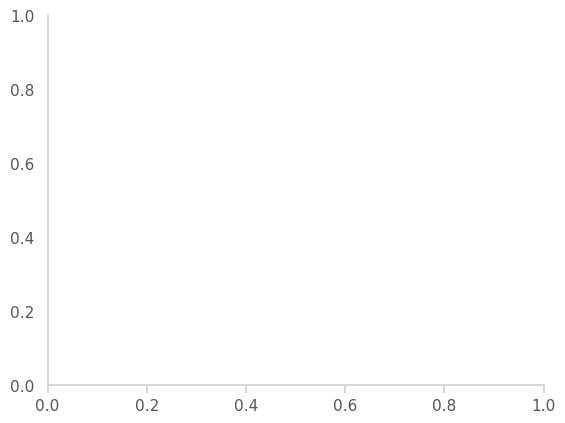

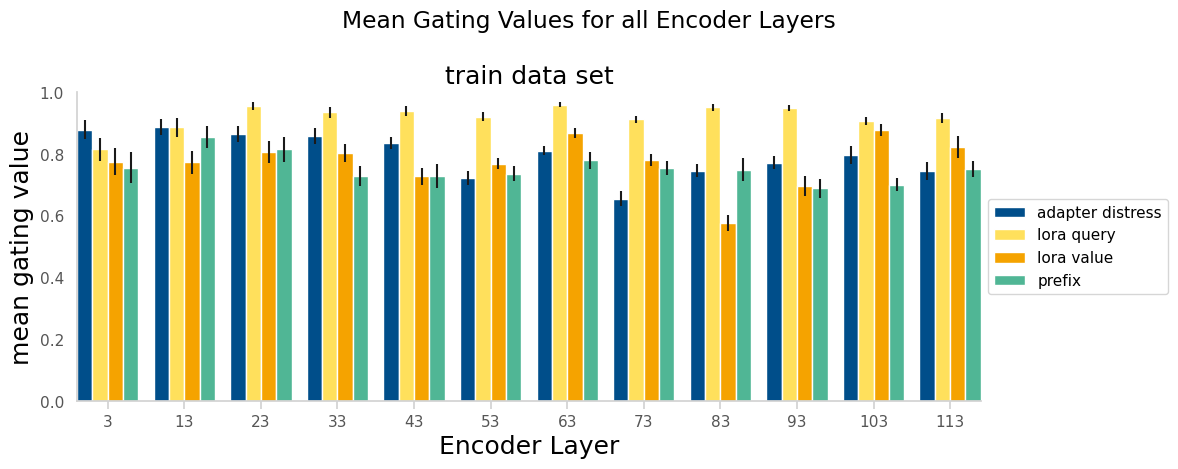

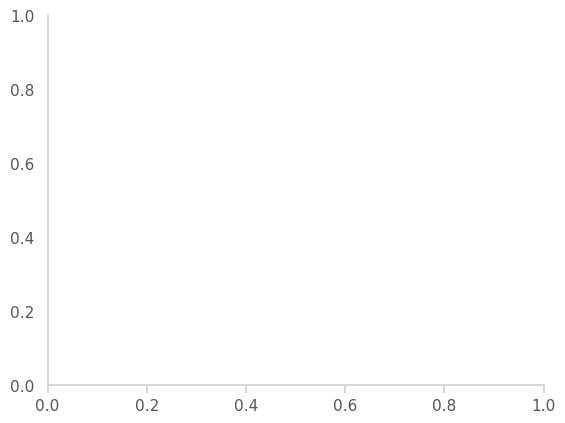

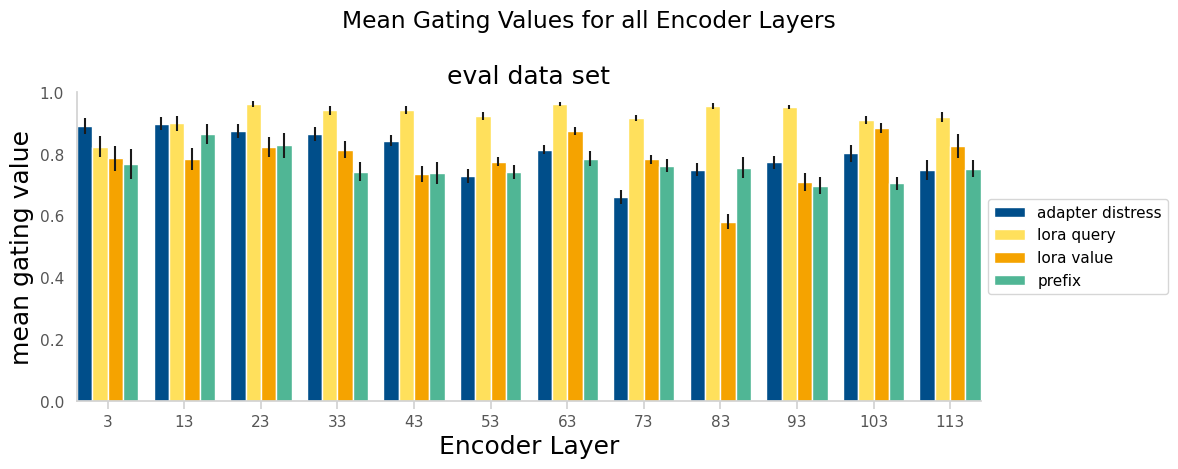

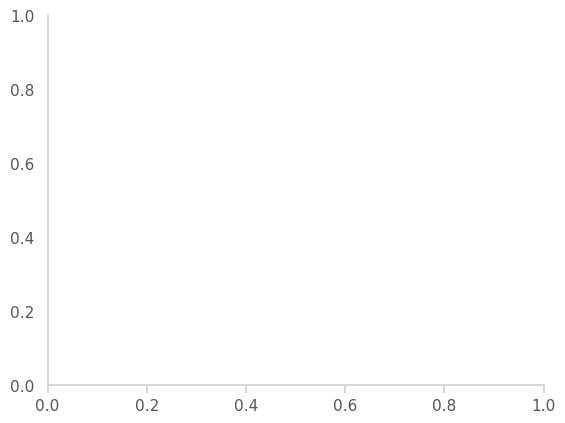

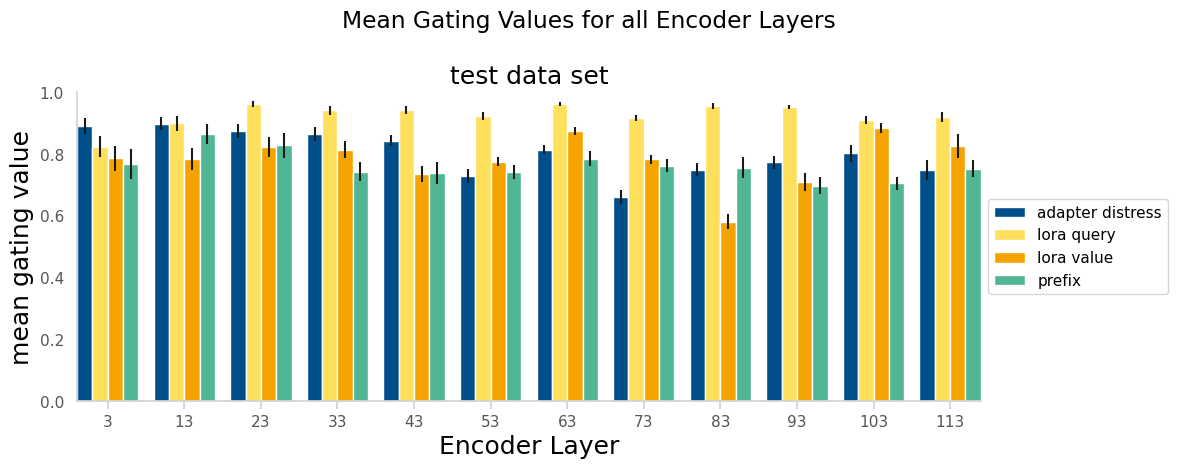

In [22]:

encoder_layers = sorted(set(gates['encoder_layer']))
# get eval and train of last epoch while in train
last_train = gates[(gates['split'] == 'train') & (gates['epoch'] == max(gates['epoch'])) & (gates['is_in_train'] == True)].reset_index()
after_train_eval = gates[(gates['split'] == 'eval') & (gates['is_in_train'] == False)].reset_index()
after_train_test = gates[(gates['split'] == 'test') & (gates['is_in_train'] == False)].reset_index()

show_plot_crit = lambda key: len(gate_per_set[key]) > 0 # criterion to not show the plot for the data set, here: if dataset not used / df is empty
gate_per_set = {'train':last_train, 'eval':after_train_eval, 'test':after_train_test}
count_data_available = sum([1 for key in gate_per_set.keys() if show_plot_crit(key)])

idx = 0
for key in gate_per_set.keys():
    if show_plot_crit(key):
        fig, axs = plt.subplots()
        dataset = gate_per_set[key]

        gating_cols = [col for col in dataset.columns if 'gate' in col]
        grouped_mean = dataset.groupby(['encoder_layer']).agg({col: 'mean' for col in gating_cols})
        grouped_std = dataset.groupby(['encoder_layer']).agg({col: 'std' for col in gating_cols})

        bar_width = 2
        width = bar_width * (len(gating_cols)) + bar_width
        x = grouped_mean.index.to_numpy() * width
        this_colors = COLORS
        if len(this_colors) < len(gating_cols):  # if not enough colors in the list
            this_colors = [COLORS[i] if i < len(COLORS) else '#000000' for i in range(len(gating_cols))]

        fig, axs = plt.subplots()
        fig.set_figwidth(len(grouped_mean))
        for idx, col in enumerate(gating_cols):
            y_pos = x + idx * bar_width
            color_i = this_colors[idx]
            label_i = col[5:].replace('-', ' ').replace('_', ' ')
            axs.bar(x=y_pos, yerr=grouped_std[col], height=grouped_mean[col], width=bar_width, label=label_i, color=color_i)#, 'gate_lora_value', 'gate_lora_query', 'gate_adapters']], label=['gate_prefix', 'gate_lora_value', 'gate_lora_query', 'gate_adapters'])
        
        axs.set_xlabel('Encoder Layer')
        #axs.set_xticklabels(grouped_mean.index.to_numpy())
        axs.set_xticks(x + ((len(gating_cols)-1) * bar_width)/2)
        axs.set_title(f'{key} data set')
        axs.set_xlim(x[0]-bar_width/2, x[-1] + ((len(gating_cols)-1) * bar_width) + bar_width/2)
        axs.set_ylim(0,1)
        axs.set_ylabel('mean gating value')
        axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        fig.suptitle('Mean Gating Values for all Encoder Layers')
        fig.tight_layout()
        title = f'{key}/gating_layers'
        fig.savefig(output_dir + '/plots/' + title.replace('/', '_') + '.pdf', bbox_inches='tight', dpi=plt.gcf().dpi)
        #plt.close()
        #fig.show()

# Generate output for a model

In [23]:
def generate_result_file(model_name, output_dir='../output/', store_as_tsv=True, columns=['empathy', 'distress']):
    """Loading from results file of a model and generate an output file

    Args:
        model_name (_type_): _description_
        output_dir (str, optional): _description_. Defaults to '../output/'.
        store_as_tsv (bool, optional): _description_. Defaults to True.
        columns (list, optional): _description_. Defaults to ['empathy', 'distress'].
    """
    model_dir = output_dir + model_name + '/'

    subdirs = [x[0] for x in os.walk(model_dir)] 
    subdirs = [subdir for subdir in subdirs if subdir[-1]!='/']
    # check which subtasks_are available
    output_task_paths = {subdir.split('/')[-1]: subdir for subdir in subdirs}

    test_result_file_name = 'test_results'
    results_df = pd.DataFrame()
    for col in columns:
        if col in output_task_paths.keys():
            test_file_path = output_task_paths[col] + f'/{test_result_file_name}_{col}.txt'
            task_results = pd.read_csv(test_file_path, sep='\t', index_col=0, header=0)['prediction']
            results_df[col] = task_results
        else:
            print(f'For {model_name}: Task {col} not available. Will not be stored')

    # sort by columns: make sure, empathy is the first column. Important for the tsv generation
    results_df = results_df.sort_index(axis=1, ascending=False)

    if store_as_tsv:
        results_df.to_csv(model_dir + test_result_file_name + '.tsv', index=None, header=None, sep='\t')
    else:
        results_df.to_csv(model_dir + test_result_file_name + '.csv')

generate_result_file('multiinput_pelt_unified_apl_bert_1e-4', output_dir=output_dir)

# Error Analysis of the outcome

## Load the data

In [65]:
model_name = 'multiinput_pelt_unified_apl_bert_1e-4'
model_dir = output_dir + model_name + '/distress/'
file_name = 'eval_gates_w_ids.csv'
gates_ids = pd.read_csv(model_dir + file_name, index_col=0, header=0)
gates_ids

,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix,encoder_layer,epoch,split,is_in_train,message_id
0,0.894473,0.839693,0.803292,0.788053,0,15.0,test,False,R_3QLVVnAgRBRH41U_1
171,0.916579,0.867609,0.843520,0.840535,0,15.0,test,False,R_3QLVVnAgRBRH41U_2
172,0.885984,0.830554,0.801213,0.786674,0,15.0,test,False,R_3QLVVnAgRBRH41U_3
173,0.896545,0.846610,0.817105,0.812377,0,15.0,test,False,R_3QLVVnAgRBRH41U_4
174,0.908246,0.857308,0.827926,0.819979,0,15.0,test,False,R_3QLVVnAgRBRH41U_5
...,...,...,...,...,...,...,...,...,...
3065,0.797300,0.934055,0.859162,0.731819,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_1
3066,0.736161,0.923027,0.830039,0.781348,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_2
3067,0.742484,0.908529,0.786875,0.703903,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_3
3053,0.727163,0.928976,0.815288,0.752826,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_4


## Load and Map articles on the data based on message ID

In [66]:
# the news articles
articles = utils.load_articles(data_root_folder="../data/")
# dev and train data
data_train, data_dev = utils.load_data(data_root_folder="../data/")
data_dev['message_id']

0      R_3QLVVnAgRBRH41U_1
1      R_3QLVVnAgRBRH41U_2
2      R_3QLVVnAgRBRH41U_3
3      R_3QLVVnAgRBRH41U_4
4      R_3QLVVnAgRBRH41U_5
              ...         
265    R_r3CoQ7YjIwxVvJT_1
266    R_r3CoQ7YjIwxVvJT_2
267    R_r3CoQ7YjIwxVvJT_3
268    R_r3CoQ7YjIwxVvJT_4
269    R_r3CoQ7YjIwxVvJT_5
Name: message_id, Length: 270, dtype: object

In [73]:
shorten_data_dev = data_dev[['message_id', 'essay', 'empathy', 'distress', 'article_id', 'emotion']]
shorten_data_dev = shorten_data_dev.set_index('message_id')

joined_data = gates_ids.join(shorten_data_dev, on='message_id', how='left')
joined_data

,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix,encoder_layer,epoch,split,is_in_train,message_id,essay,empathy,distress,article_id,emotion
0,0.894473,0.839693,0.803292,0.788053,0,15.0,test,False,R_3QLVVnAgRBRH41U_1,The story about the air strikes is very sadden...,7.000,7.000,13,sadness
171,0.916579,0.867609,0.843520,0.840535,0,15.0,test,False,R_3QLVVnAgRBRH41U_2,It is clear that climate change is something t...,3.167,3.625,127,sadness
172,0.885984,0.830554,0.801213,0.786674,0,15.0,test,False,R_3QLVVnAgRBRH41U_3,I did not know this comedian but thinking abou...,4.500,3.125,188,fear
173,0.896545,0.846610,0.817105,0.812377,0,15.0,test,False,R_3QLVVnAgRBRH41U_4,I am an affirmed believer that your punishment...,2.000,2.000,307,anger
174,0.908246,0.857308,0.827926,0.819979,0,15.0,test,False,R_3QLVVnAgRBRH41U_5,"Okay, I hate hearing about disease outbreaks. ...",4.500,4.625,409,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065,0.797300,0.934055,0.859162,0.731819,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_1,"While I feel bad for the arrest charges, I don...",2.000,2.250,2,anger
3066,0.736161,0.923027,0.830039,0.781348,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_2,This is such a tragedy. All I can think about...,4.500,5.625,131,fear
3067,0.742484,0.908529,0.786875,0.703903,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_3,I'm still on the fence regarding climate chang...,1.833,2.375,230,neutral
3053,0.727163,0.928976,0.815288,0.752826,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_4,I can understand why the Jewish community woul...,1.833,1.375,326,joy


# Calculate Error of the predictions